<a href="https://colab.research.google.com/github/goutamkumar120/DATA-SCIENCE-PROJECT/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/test.csv')

In [ ]:
train.head()

## Label 1 is unreliable and 0 is reliable

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [ ]:
train.fillna(' ', inplace = True)
test.fillna(' ', inplace = True)

## All the null values were filled with spaces.

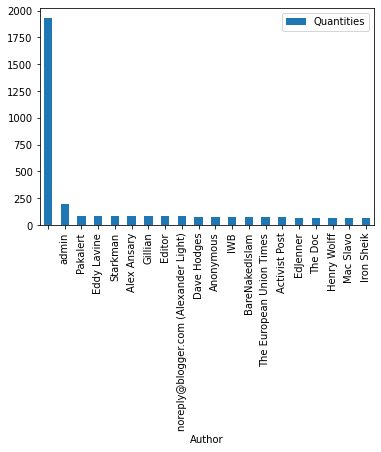

In [ ]:
train_new = pd.DataFrame({'Author' : train[train['label'] == 1]['author'].value_counts().head(20).index, 'Quantities' : train[train['label'] == 1]['author'].value_counts().head(20)})
unreliable_plot = train_new.plot(kind = 'bar', x = 'Author', y = 'Quantities')
unreliable_plot

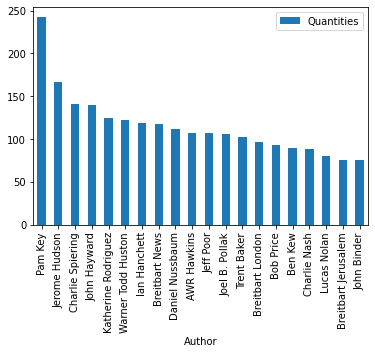

In [ ]:
train_new_reliable = pd.DataFrame({'Author' : train[train['label'] == 0]['author'].value_counts().head(20).index, 'Quantities' : train[train['label'] == 0]['author'].value_counts().head(20)})
reliable_plot = train_new_reliable.plot(kind = 'bar', x = 'Author', y = 'Quantities')
reliable_plot

In [ ]:
unreliable_count = len(train[train['label'] == 1])
reliable_count = len(train[train['label'] == 0])

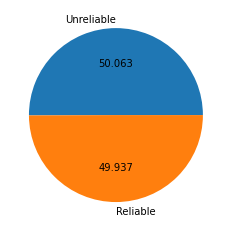

In [ ]:
x = np.array([unreliable_count, reliable_count])
mylabels = ['Unreliable', 'Reliable']
plt.pie(x, labels = mylabels, autopct = '%.3f')
plt.show()

In [ ]:
train['total'] = train['title'] + train['author']
test['total'] = test['title'] + test['author']

In [ ]:
stemmer = PorterStemmer()

def porterstemmer(text):
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(words) for words in review if words not in stopwords.words('english') and words.isalpha()]
    review = ' '.join(review)
    return review


## This helps us to remove the stopwords and also to trim the important words and this is the first data preprocessing step.

In [ ]:
train['clean_total'] = train['total'].apply(porterstemmer)
test['clean_total'] = test['total'].apply(porterstemmer)

In [ ]:
df_train = train[['title', 'label']]

In [ ]:
unreliable_title = df_train[df_train['label'] == 1]['title']
reliable_title = df_train[df_train['label'] == 0]['title']

In [ ]:
common_words_reliable = pd.Series(' '.join([str(i) for i in reliable_title]).split()).value_counts().head(30).index
common_words_unreliable = pd.Series(' '.join([str(i) for i in unreliable_title]).split()).value_counts().head(30).index

In [ ]:
common_words = set(common_words_reliable).intersection(common_words_unreliable)

In [ ]:
def text_cleaning(data):
  review = [i for i in data.split() if i not in common_words]
  return review

## All the common words in the first 30 entries were removed from the data.

In [ ]:
train['new_total'] = train['clean_total'].apply(text_cleaning)
test['new_total'] = test['clean_total'].apply(text_cleaning)

In [ ]:
np.max(train['new_total'].apply(lambda x : len(x)))

50

In [ ]:
train = train.drop(columns = ['text', 'id'])
test = test.drop(columns = ['text', 'id'])


## Unnecessary columns were removed.

In [ ]:
## Function to do produce a tf-idf frequency matrix
corpus_vectorizer = TfidfVectorizer(norm = None)

def tf_idf_matrix(corp):
  tf_idf_scores = corpus_vectorizer.fit_transform(corp)
  feature_names = corpus_vectorizer.get_feature_names()
  df = pd.DataFrame(tf_idf_scores.T.todense(), index = feature_names, columns = [i for i in range(1, len(corp)+1)])
  return df

In [ ]:
document = train['clean_total']
df = tf_idf_matrix(document)

In [ ]:
lst = []
for k in range(1, 20801): 
  x = df[k].where(df[k].values > 0.0)
  x.fillna(0.0, inplace = True)
  y = []
  for i in x:
    if i > 0.0:
      y.append(i)

  lst.append(y)


## From the sparse tf-idf matrix only the values that were not 0 were taken.

In [ ]:
main_df = pd.DataFrame(lst, columns = [i for i in range(1,47)])
main_df.fillna(0.0, inplace = True)
main_df

## And the main dataframe was formed from those values and even though this matrix is sparse it is almost 500 times smaller than the size of the previous one.

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,6.368045,8.640171,5.849006,6.357789,5.487435,5.174435,10.249609,7.723881,6.899705,8.544861,6.044917,6.783873,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.880161,7.387408,7.646919,3.844381,14.272188,3.842729,6.030101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.758607,10.249609,5.165104,7.331838,6.548307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.359237,7.010931,10.249609,5.187014,10.249609,7.575461,4.835733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.249609,6.037482,8.996846,7.723881,7.092609,7.136094,7.998317,6.476848,10.249609,12.060203,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,6.399462,5.760973,7.071555,8.377807,8.303699,9.333318,2.769181,5.190184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20796,7.947024,9.556462,2.124274,8.745532,8.745532,8.544861,7.508769,2.197950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20797,7.851714,8.109543,8.863315,5.595649,5.760973,5.899331,9.556462,7.807262,2.124274,6.972464,7.205087,6.560730,8.544861,5.297309,2.19795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20798,6.511940,10.249609,8.544861,6.799622,6.723249,9.333318,4.750394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And then the test and training accuracy was tested upon the dataset by using a KNeighborsClassifier, SVMs and Logistic Regression. Then all of them were tried on the test dataset to get the accuracies.

In [ ]:
X = main_df[0:].to_numpy()
y = train.label.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

In [ ]:
k_range = range(1, 21)
scores_training = []
scores_testing = []
scores_precision = []
for i in k_range:
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train, y_train)
  scores_training.append(knn.score(X_train, y_train))
  scores_testing.append(knn.score(X_test, y_test))
  scores_precision.append(precision_score(knn.predict(X_test), y_test))


## This helps in picking the best value of k in KNeighborsClassifier

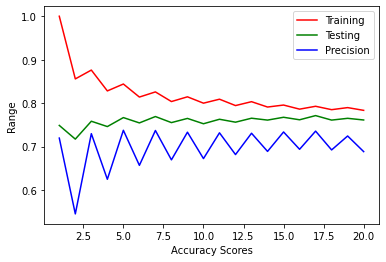

In [ ]:
plt.plot(k_range, scores_training, color = 'r', label = 'Training')
plt.plot(k_range, scores_testing, color = 'g', label = 'Testing')
plt.plot(k_range, scores_precision, color = 'b', label = 'Precision')
plt.xlabel('Accuracy Scores')
plt.ylabel('Range')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
knn_df = pd.DataFrame([scores_training, scores_testing, scores_precision], index = ['Training', 'Testing', 'Precision'])
knn_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Training,1.000000,0.855829,0.876142,0.828185,0.844050,0.814063,0.825901,0.803726,0.814603,0.800000,0.809135,0.794471,0.803425,0.791106,0.795673,0.786238,0.792849,0.785036,0.789784,0.783474
Testing,0.748798,0.717308,0.758413,0.746154,0.766827,0.754567,0.769231,0.755288,0.764904,0.752644,0.762981,0.756250,0.765385,0.761058,0.767548,0.761779,0.771394,0.761058,0.765144,0.761298
Precision,0.719631,0.545190,0.729835,0.624879,0.737609,0.656948,0.737123,0.669582,0.733236,0.672498,0.731778,0.681730,0.730807,0.689018,0.733722,0.693878,0.735666,0.692420,0.724490,0.688533


In [ ]:
!pip install kneed

3


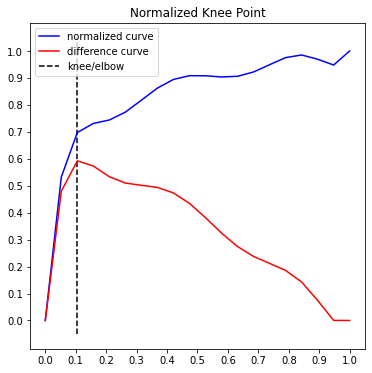

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(x = range(1, 21), y = scores_training, curve = 'convex', direction = 'decreasing', S = 1, interp_method = 'polynomial')
kl.plot_knee_normalized()
print(kl.knee)

2


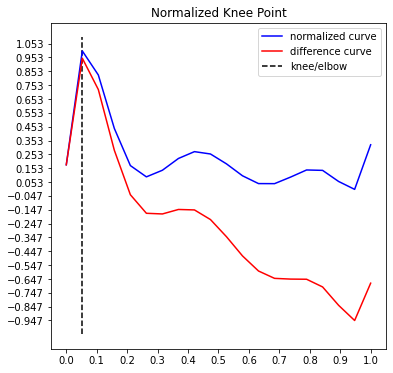

In [ ]:
kl = KneeLocator(x = range(1, 21), y = scores_precision, curve = 'convex', direction = 'decreasing', S = 1, interp_method = 'polynomial')
kl.plot_knee_normalized()
print(kl.knee)

In [ ]:
param_grid = {'C' : [1, 10, 100],
              'gamma' : [1, 0.1, 0.01],
              'kernel' : ['rbf'],
              'degree' : [3, 4, 5]}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.627, total= 1.0min
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.629, total=  59.4s
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.633, total=  59.2s
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.623, total=  59.3s
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................
[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.633, total= 1.0min
[CV] C=1, degree=3, gamma=0.1, kernel=rbf ............................
[CV]  C=1, degree=3, gamma=0.1, kernel=rbf, score=0.773, total=  40.1s
[CV] C=1, degree=3, gamma=0.1, kernel=rbf ............................
[CV]  C=1, degree=3, gamma=0.1, kernel=rbf, score=0.776, total=  40.3s
[CV] C=1, degree=3, gamma=0.1, kernel=rbf ............................
[CV]  C=1, degree=3, gamma=0.1, kernel=rbf, score=0.764, total=  50.4s
[CV] C=1, degree=3, gamma=0.1, kernel=rbf ............................
[CV]  C=1, degree=3, gamma=0.1, kernel=rbf, score=0.753, total=  40.9s
[CV] C=1, degree=3, gamma=0.1, kernel=rbf ............................
[CV]  C=1, degree=3, gamma=0.1, kernel=rbf, score=0.765, total=  40.5s
[CV] C=1, degree=3, gamma=0.01, kernel=rbf ...........................
[CV]  

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 116.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'degree': [3, 4, 5],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
svc = SVC(C = 100, kernel = 'rbf', gamma = 0.01, degree = 3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [ ]:
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))
print(precision_score(y_pred, y_test))

0.8832331730769231
0.7908653846153846
0.8333333333333334


In [ ]:
logreg_grid = {'C' : [0.01, 0.1, 1, 10],
               'solver' : ['saga', 'liblinear'],
               'penalty' : ['l1', 'l2', 'elasticnet'],
               'l1_ratio' : [0.2, 0.4, 0.5]}

grid_logreg = GridSearchCV(LogisticRegression(max_iter = 50000), logreg_grid, verbose = 4, refit = True)
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=saga ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=saga, score=0.671, total=   2.5s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=saga ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=saga, score=0.670, total=   2.5s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=saga ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=saga, score=0.653, total=   2.2s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=saga ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=saga, score=0.648, total=   2.6s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=saga, score=0.658, total=   2.7s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.665, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.661, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.651, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.639, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.665, total=   0.2s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=saga, score=0.672, total=   2.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=saga, score=0.667, total=   2.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=saga, score=0.654, total=   1.8s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=saga, score=0.646, total=   2.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=saga, score=0.658, total=   2.2s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.675, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.666, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.657, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.644, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.663, total=   0.1s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga ...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.672, total=   2.7s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.667, total=   2.7s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.654, total=   2.2s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.647, total=   2.6s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.658, total=   2.8s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.2, penalty=elastic

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=saga, score=0.671, total=   2.5s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=saga, score=0.670, total=   2.5s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=saga, score=0.653, total=   2.2s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=saga, score=0.648, total=   2.5s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=saga, score=0.658, total=   2.6s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.665, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.661, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.651, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.639, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.665, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=saga, score=0.672, total=   2.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=saga, score=0.667, total=   2.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=saga, score=0.654, total=   1.8s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=saga, score=0.646, total=   2.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=saga, score=0.658, total=   2.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.675, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.666, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.657, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.644, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.663, total=   0.1s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga ...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.672, total=   2.7s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.668, total=   2.7s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.654, total=   2.3s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.648, total=   2.7s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.659, total=   2.8s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.4, penalty=elastic

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=saga, score=0.671, total=   2.5s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=saga, score=0.670, total=   2.5s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=saga, score=0.653, total=   2.2s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=saga, score=0.648, total=   2.7s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=saga, score=0.658, total=   2.7s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.665, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.661, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.651, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.639, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.665, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=saga, score=0.672, total=   2.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=saga, score=0.667, total=   2.2s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=saga, score=0.654, total=   1.9s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=saga, score=0.646, total=   2.2s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=saga ...................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=saga, score=0.658, total=   2.2s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.675, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.666, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.657, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.644, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear ..............
[CV]  C=0.01, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.663, total=   0.1s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga ...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.672, total=   2.7s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.669, total=   2.7s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.653, total=   2.3s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.648, total=   2.8s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga ...........
[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.657, total=   2.8s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.01, l1_ratio=0.5, penalty=elasticnet, solver=liblinear ......
[CV]  C=0.01, l1_ratio=0.5, penalty=elastic

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.673, total=   3.9s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.666, total=   3.8s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.654, total=   2.0s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.646, total=   6.5s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.659, total=   4.6s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.671, total=   0.2s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.669, total=   0.2s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.654, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.646, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.673, total=   6.4s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.666, total=   4.7s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.654, total=   5.8s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.646, total=   4.9s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.658, total=   5.6s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.672, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.668, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.646, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.660, total=   0.1s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga ............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.672, total=   7.7s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.666, total=   6.3s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.654, total=   8.1s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.646, total=   6.7s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.658, total=   7.2s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.2, penalty=elasticnet, so

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.673, total=   3.9s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.666, total=   3.9s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.654, total=   2.0s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.646, total=   6.3s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.659, total=   4.8s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.671, total=   0.2s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.669, total=   0.2s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.654, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.646, total=   0.2s
[CV] C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.673, total=   6.4s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.666, total=   4.6s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.654, total=   5.7s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.646, total=   5.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.658, total=   5.8s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.672, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.668, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.646, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.660, total=   0.1s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga ............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.672, total=   5.9s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.667, total=   6.7s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.654, total=   8.4s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.647, total=   7.2s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.658, total=   6.6s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.4, penalty=elasticnet, so

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.673, total=   3.8s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.666, total=   3.7s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.654, total=   1.9s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.646, total=   6.4s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.659, total=   4.8s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.671, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.669, total=   0.2s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.654, total=   0.2s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.646, total=   0.2s
[CV] C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.673, total=   6.4s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.666, total=   4.8s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.654, total=   5.6s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.646, total=   4.8s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=saga ....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.658, total=   5.5s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.672, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.668, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear ...............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.646, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear ...............
[CV]  C=0.1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.660, total=   0.1s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga ............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.673, total=   5.2s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.666, total=   6.9s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.654, total=   7.5s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.647, total=   7.2s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga ............
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.658, total=   6.5s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear .......
[CV]  C=0.1, l1_ratio=0.5, penalty=elasticnet, so

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.672, total=  16.7s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.666, total=  13.9s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.654, total=  34.2s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.646, total=  15.4s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=saga, score=0.658, total=  15.0s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.673, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.667, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.654, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.658, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.672, total=  21.8s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.666, total=  12.8s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.654, total=  20.2s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.647, total=  13.7s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=saga, score=0.658, total=  14.3s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.666, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.2, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.659, total=   0.1s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.673, total=  28.0s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.666, total=  17.3s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.654, total=  27.3s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.647, total=  18.2s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.658, total=  18.3s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.2, penalty=elasticnet, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.672, total=  16.9s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.666, total=  14.1s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.654, total=  33.8s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.646, total=  15.6s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=saga, score=0.658, total=  15.0s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.673, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.667, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.654, total=   0.1s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.658, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.672, total=  21.8s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.666, total=  12.8s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.654, total=  20.1s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.647, total=  13.7s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=saga, score=0.658, total=  13.9s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.666, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.4, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.659, total=   0.1s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.673, total=  27.4s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.666, total=  17.2s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.654, total=  30.0s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.647, total=  18.2s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.658, total=  18.2s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.4, penalty=elasticnet, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.672, total=  16.6s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.666, total=  14.1s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.654, total=  34.3s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.646, total=  15.9s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=saga, score=0.658, total=  15.2s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.673, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.667, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.654, total=   0.1s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l1, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.658, total=   0.1s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.672, total=  22.1s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.666, total=  12.9s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.654, total=  20.3s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.647, total=  13.8s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=saga ......................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=saga, score=0.658, total=  14.4s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.666, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.654, total=   0.1s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=liblinear .................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=1, l1_ratio=0.5, penalty=l2, solver=liblinear .................
[CV]  C=1, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.659, total=   0.1s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga ..............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.673, total=  27.2s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.666, total=  16.3s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.654, total=  29.0s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.647, total=  18.3s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga ..............
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.658, total=  17.8s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear .........
[CV]  C=1, l1_ratio=0.5, penalty=elasticnet, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=saga, score=0.672, total=  46.3s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=saga, score=0.666, total=  27.3s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=saga, score=0.654, total=  40.3s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=saga, score=0.647, total=  28.5s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=saga, score=0.658, total=  27.3s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.666, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=saga, score=0.672, total=  35.6s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=saga, score=0.666, total=  21.7s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=saga, score=0.654, total=  32.3s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=saga, score=0.647, total=  22.6s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=saga, score=0.658, total=  22.1s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.666, total=   0.1s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.2, penalty=l2, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga .............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.672, total=  47.0s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.666, total=  28.5s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.654, total=  41.4s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.647, total=  29.3s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=saga, score=0.658, total=  28.4s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, l1_ratio=0.2, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.2, penalty=elasticnet, solver=li

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=saga, score=0.672, total=  46.1s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=saga, score=0.666, total=  27.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=saga, score=0.654, total=  40.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=saga, score=0.647, total=  28.7s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=saga, score=0.658, total=  27.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.666, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=saga, score=0.672, total=  35.5s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=saga, score=0.666, total=  21.5s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=saga, score=0.654, total=  32.0s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=saga, score=0.647, total=  22.5s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=saga, score=0.658, total=  21.6s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.666, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.4, penalty=l2, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga .............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.672, total=  46.4s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.666, total=  28.4s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.654, total=  41.5s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.647, total=  29.5s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=saga, score=0.658, total=  28.4s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, l1_ratio=0.4, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.4, penalty=elasticnet, solver=li

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=saga, score=0.672, total=  46.3s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=saga, score=0.666, total=  27.5s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=saga, score=0.654, total=  40.5s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=saga, score=0.647, total=  28.3s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=saga, score=0.658, total=  27.3s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.666, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l1, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l1, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=saga, score=0.672, total=  35.4s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=saga, score=0.666, total=  21.6s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=saga, score=0.654, total=  31.9s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=saga, score=0.647, total=  22.5s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=saga .....................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=saga, score=0.658, total=  21.8s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.672, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.666, total=   0.1s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.654, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=liblinear ................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.647, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=l2, solver=liblinear ................
[CV]  C=10, l1_ratio=0.5, penalty=l2, solver=liblinear, score=0.659, total=   0.2s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga .............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.672, total=  46.6s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.666, total=  28.3s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.654, total=  41.2s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.647, total=  29.0s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga .............
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=saga, score=0.658, total=  28.0s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, l1_ratio=0.5, penalty=elasticnet, solver=liblinear ........
[CV]  C=10, l1_ratio=0.5, penalty=elasticnet, solver=li

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 44.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=50000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.4, 0.5],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4)

In [ ]:
print(grid_logreg.best_params_)
print(grid_logreg.best_estimator_)
print(grid_logreg.best_score_)

{'C': 0.01, 'l1_ratio': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=50000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
0.6612379807692308


In [ ]:
logreg = LogisticRegression(C = 0.01, l1_ratio = 0.2, penalty = 'l2', solver = 'liblinear', max_iter = 50000)
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=50000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))
print(precision_score(logreg.predict(X_test), y_test))

0.66328125
0.6721153846153847
0.6000971817298348


In [ ]:
##Now doing the prediction with the help of adaboost classifiers
adaboost_grid = {'n_estimators' : [100, 150, 200, 250],
                 'algorithm' : ['SAMME.R', 'SAMME'],
                 'learning_rate' : [0.2, 0.5, 0.8]}

grid_clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1)), adaboost_grid, refit = True, verbose = 4)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=100, score=0.789, total=   1.8s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=100, score=0.779, total=   1.8s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=100, score=0.765, total=   1.8s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=100 ..........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=100, score=0.754, total=   1.8s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=100 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=100, score=0.776, total=   1.8s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=150 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=150, score=0.798, total=   2.7s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=150 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=150, score=0.789, total=   2.7s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=150 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=150, score=0.783, total=   2.7s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=150 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.2, n_estimators=150, score=0.763, total=   2.7s
[CV] algorithm=SAMME.R, learning_rate=0.2, n_estimators=150 ..........
[CV]  algorithm=SAMME.R, learning_rate=0

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), algorithm = 'SAMME.R', learning_rate = 0.8, n_estimators = 250)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
print(ada_clf.score(X_train, y_train))
print(ada_clf.score(X_test, y_test))
print(precision_score(ada_clf.predict(X_test), y_test))

0.8364783653846154
0.833173076923077
0.8440233236151603


In [ ]:
rf_grid = {'n_estimators' : [200, 250, 300, 350],
           'max_depth' : [16, 20, 24],
           'criterion' : ['gini', 'entropy']}

rf_grid_clf = GridSearchCV(RandomForestClassifier(bootstrap = True, oob_score = True), rf_grid, refit = True, verbose = 4)
rf_grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=gini, max_depth=16, n_estimators=200 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=16, n_estimators=200, score=0.841, total=   3.8s
[CV] criterion=gini, max_depth=16, n_estimators=200 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  criterion=gini, max_depth=16, n_estimators=200, score=0.831, total=   3.7s
[CV] criterion=gini, max_depth=16, n_estimators=200 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=16, n_estimators=200, score=0.818, total=   3.7s
[CV] criterion=gini, max_depth=16, n_estimators=200 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=16, n_estimators=200, score=0.800, total=   3.8s
[CV] criterion=gini, max_depth=16, n_estimators=200 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=200, score=0.828, total=   3.7s
[CV] criterion=gini, max_depth=16, n_estimators=250 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=250, score=0.837, total=   4.7s
[CV] criterion=gini, max_depth=16, n_estimators=250 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=250, score=0.833, total=   4.6s
[CV] criterion=gini, max_depth=16, n_estimators=250 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=250, score=0.822, total=   4.7s
[CV] criterion=gini, max_depth=16, n_estimators=250 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=250, score=0.803, total=   4.7s
[CV] criterion=gini, max_depth=16, n_estimators=250 ..................
[CV]  criterion=gini, max_depth=16, n_estimators=250, score=0.826, total=   4.7s
[CV] cr

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                              

In [ ]:
print(rf_grid_clf.best_params_)
print(rf_grid_clf.best_estimator_)
print(rf_grid_clf.best_score_)

{'criterion': 'entropy', 'max_depth': 24, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
0.8365985576923076


In [ ]:
rf_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 24, n_estimators = 300)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))
print(precision_score(rf_clf.predict(X_test), y_test))

0.9907451923076923
0.8444711538461539
0.8629737609329446


In [ ]:
xgb_clf = XGBClassifier(learning_rate=0.8)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print(xgb_clf.score(X_train, y_train))
print(xgb_clf.score(X_test, y_test))
print(precision_score(xgb_clf.predict(X_test), y_test))

0.9141225961538462
0.8769230769230769
0.892128279883382


In [ ]:
test_doc = test['clean_total']
test_df = tf_idf_matrix(test_doc)

## Now to create the dataset upon which predictions will be done.

In [ ]:
lst = []
for k in range(1, 5201): 
  x = test_df[k].where(test_df[k].values > 0.0)
  x.fillna(0.0, inplace = True)
  y = []
  for i in x:
    if i > 0.0:
      y.append(i)

  lst.append(y)

In [ ]:
df_test = pd.DataFrame(lst, columns = [i for i in range(1, 26)])
df_test.fillna(0.0, inplace = True)
df_test

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,8.863459,2.114113,8.863459,7.477165,8.863459,8.457994,8.863459,6.122619,8.863459,2.788113,7.359382,2.183860,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.560874,6.560874,6.917549,5.187158,6.378552,6.122619,7.947168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.024007,6.991657,6.723393,7.254021,5.727965,8.170312,7.947168,8.863459,6.991657,6.666234,6.991657,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.337730,7.158711,7.947168,8.170312,2.114113,8.457994,6.723393,4.720324,6.917549,7.071700,2.183860,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.477165,8.863459,8.457994,6.337730,4.820408,6.421112,5.090698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,8.863459,6.001258,8.863459,6.723393,2.114113,8.863459,8.863459,7.947168,2.183860,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5196,7.158711,5.706459,6.512084,5.397723,8.170312,7.477165,2.114113,7.158711,4.971639,8.170312,6.260769,7.947168,8.170312,8.457994,2.18386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5197,5.945688,8.863459,6.784017,2.114113,8.170312,6.189310,6.337730,2.183860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5198,5.919020,7.477165,6.991657,7.947168,5.187158,4.593762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## Now adding more columns to make the test and train dataframes same.

for i in range(25, 47):
  df_test[i] = 0.0

df_test

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,8.863459,2.114113,8.863459,7.477165,8.863459,8.457994,8.863459,6.122619,8.863459,2.788113,7.359382,2.183860,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.560874,6.560874,6.917549,5.187158,6.378552,6.122619,7.947168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.024007,6.991657,6.723393,7.254021,5.727965,8.170312,7.947168,8.863459,6.991657,6.666234,6.991657,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.337730,7.158711,7.947168,8.170312,2.114113,8.457994,6.723393,4.720324,6.917549,7.071700,2.183860,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.477165,8.863459,8.457994,6.337730,4.820408,6.421112,5.090698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,8.863459,6.001258,8.863459,6.723393,2.114113,8.863459,8.863459,7.947168,2.183860,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5196,7.158711,5.706459,6.512084,5.397723,8.170312,7.477165,2.114113,7.158711,4.971639,8.170312,6.260769,7.947168,8.170312,8.457994,2.18386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5197,5.945688,8.863459,6.784017,2.114113,8.170312,6.189310,6.337730,2.183860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5198,5.919020,7.477165,6.991657,7.947168,5.187158,4.593762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_array = df_test[0:].to_numpy()             ##This is the array upon which predictions will be done.
y = train.label.to_numpy()             ##This again reassigns the value of y because it was altered in previous segments

In [ ]:
svc = SVC(C = 100, kernel = 'rbf', gamma = 0.01, degree = 3)
svc.fit(X, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicted = svc.predict(test_array)

In [ ]:
ans = pd.read_csv('/content/gdrive/MyDrive/Submission.csv')
solution = ans['label'].to_numpy()

In [ ]:
print(accuracy_score(predicted, solution))
print(precision_score(predicted, solution))
print(confusion_matrix(predicted, solution))

0.78
0.7407550077041603
[[2133  673]
 [ 471 1923]]


In [ ]:
kneighbors = KNeighborsClassifier(n_neighbors = 10, weights='distance')
kneighbors.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [ ]:
predicted_knn = kneighbors.predict(test_array)
print(accuracy_score(predicted_knn, solution))
print(precision_score(predicted_knn, solution))
print(confusion_matrix(predicted_knn, solution))

0.7576923076923077
0.6648690292758089
[[2214  870]
 [ 390 1726]]


In [ ]:
logreg = LogisticRegression(C = 0.01, penalty = 'l2', solver = 'liblinear', max_iter = 50000, random_state=42, multi_class='ovr')
logreg.fit(X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predicted_log = logreg.predict(test_array)
print(accuracy_score(predicted_log, solution))
print(precision_score(predicted_log, solution))
print(confusion_matrix(predicted_log, solution))

0.6644230769230769
0.6024653312788906
[[1891 1032]
 [ 713 1564]]


In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), algorithm = 'SAMME.R', learning_rate = 1, n_estimators = 250)
ada_clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
predicted_adaboost = ada_clf.predict(test_array)

In [ ]:
print(accuracy_score(predicted_adaboost, solution))
print(precision_score(predicted_adaboost, solution))
print(confusion_matrix(predicted_adaboost, solution))

0.7892307692307692
0.6910631741140215
[[2310  802]
 [ 294 1794]]


In [ ]:
rf_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 24, n_estimators = 300, oob_score=True)
rf_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predicted_rf = rf_clf.predict(test_array)
print(accuracy_score(predicted_rf, solution))
print(precision_score(predicted_rf, solution))
print(confusion_matrix(predicted_rf, solution))

0.815
0.7715716486902927
[[2235  593]
 [ 369 2003]]


In [ ]:
xgb_clf = XGBClassifier(learning_rate=0.8)
xgb_clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predicted_xgb = xgb_clf.predict(test_array)
print(accuracy_score(predicted_xgb, solution))
print(precision_score(predicted_xgb, solution))
print(confusion_matrix(predicted_xgb, solution))

0.8007692307692308
0.7565485362095532
[[2200  632]
 [ 404 1964]]


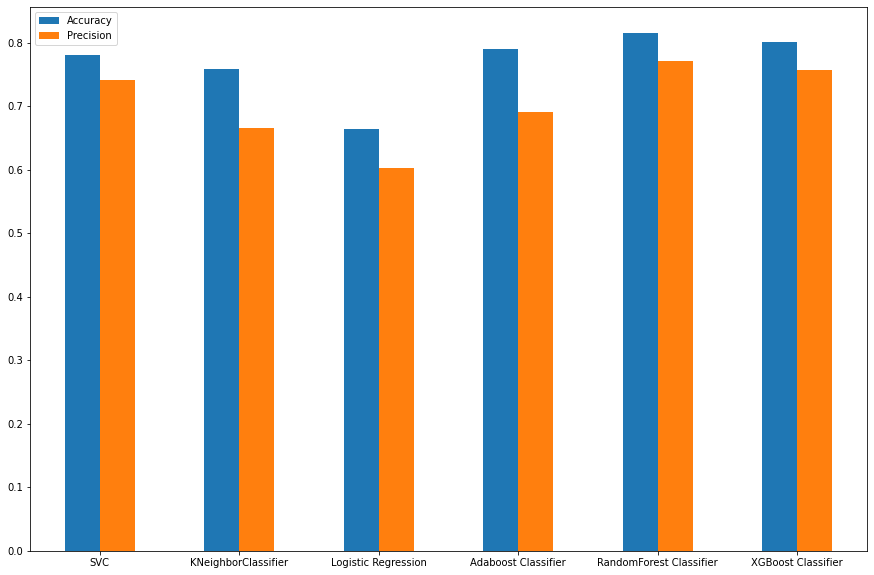

In [ ]:
accuracies = [accuracy_score(predicted, solution), accuracy_score(predicted_knn, solution), accuracy_score(predicted_log, solution), accuracy_score(predicted_adaboost, solution), accuracy_score(predicted_rf, solution), accuracy_score(predicted_xgb, solution)]
precisions = [precision_score(predicted, solution), precision_score(predicted_knn, solution), precision_score(predicted_log, solution), precision_score(predicted_adaboost, solution), precision_score(predicted_rf, solution), precision_score(predicted_xgb, solution)]
xlabels = ['SVC', 'KNeighborClassifier', 'Logistic Regression', 'Adaboost Classifier', 'RandomForest Classifier', 'XGBoost Classifier']
df = pd.DataFrame(zip(accuracies, precisions), columns=['Accuracy', 'Precision'], index=xlabels)
df.plot.bar(rot=0, figsize=(15,10))

The precision of KNeighborClassifiers and Logistic Regression are the same.And as always RandomForest Classifiers are the best classifiers of the lot. The next step is to apply Neural Networks.

In [ ]:
sentence_length = 45
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train['clean_total'])
train_total = tokenizer.texts_to_sequences(train['clean_total'])
train_total = pad_sequences(train_total,maxlen=sentence_length)
test_total = tokenizer.texts_to_sequences(test['clean_total'])
test_total = pad_sequences(test_total,maxlen=sentence_length)

In [ ]:
train_total.shape

(20800, 45)

In [ ]:
def create_model(learning_rate):
      opt = Adam(lr = learning_rate)
      embedding_vector_features=30
      model = keras.Sequential()
      model.add(layers.Embedding(60000,embedding_vector_features,input_length=sentence_length))
      model.add(layers.Dropout(0.3))
      model.add(layers.LSTM(50))
      model.add(layers.Dropout(0.3))
      model.add(layers.Dense(64,activation='relu'))
      model.add(layers.Dropout(0.3))
      model.add(layers.Dense(1,activation='relu'))
      model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])
      return model

In [ ]:
model = KerasClassifier(build_fn = create_model)

early_stop = EarlyStopping(
    monitor = 'accuracy',
    min_delta = 0.1,
    patience = 5,
    verbose = 0
)
callbacks = [early_stop]
params = {
          'learning_rate' : [0.1, 0.01, 0.001],
          'batch_size': [64],
          'callbacks':callbacks,
          'epochs' :[25]
          }
random_search = RandomizedSearchCV(model, param_distributions=params, cv=KFold(3), n_jobs=1, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, verbose=1, mode='min')

In [ ]:
X = train_total
y = train['label']

In [ ]:
random_search.fit(X, y)

print('Best score obtained: {0}'.format(random_search.best_score_))
print('Parameters:')
for param, value in random_search.best_params_.items():
    print('\t{}: {}'.format(param, value))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/25
217/217 [==============================] - 20s 80ms/step - loss: 0.7877 - accuracy: 0.4960
Epoch 2/25
217/217 [==============================] - 17s 80ms/step - loss: 0.6667 - accuracy: 0.5415
Epoch 3/25
217/217 [==============================] - 17s 79ms/step - loss: 0.6822 - accuracy: 0.6471
Epoch 4/25
217/217 [==============================] - 18s 81ms/step - loss: 0.7302 - accuracy: 0.6834
Epoch 5/25
217/217 [==============================] - 18s 82ms/step - loss: 0.7110 - accuracy: 0.6829
Epoch 6/25
217/217 [==============================] - 17s 79ms/step - loss: 0.5855 - accuracy: 0.7319
Epoch 7/25
217/217 [==============================] - 17s 81ms/step - loss: 0.5454 - accuracy: 0.7484
Epoch 8/25
217/217 [==============================] - 17s 80ms/step - loss: 0.5348 - accuracy: 0.7545
Epoch 9/25
217/217 [==============================] - 17s 80ms/step - loss: 0.5135 - accuracy: 0.7726
Epoch 10/25
217/217 [==

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.4min finished


Epoch 1/25
325/325 [==============================] - 26s 73ms/step - loss: 0.1602 - accuracy: 0.9337
Epoch 2/25
325/325 [==============================] - 24s 73ms/step - loss: 0.0124 - accuracy: 0.9961
Epoch 3/25
325/325 [==============================] - 24s 73ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 4/25
325/325 [==============================] - 24s 73ms/step - loss: 9.9023e-04 - accuracy: 0.9998
Epoch 5/25
325/325 [==============================] - 24s 73ms/step - loss: 2.9012e-04 - accuracy: 1.0000
Epoch 6/25
325/325 [==============================] - 24s 73ms/step - loss: 4.5439e-04 - accuracy: 0.9999
Best score obtained: 0.989375094572703
Parameters:
	learning_rate: 0.001
	epochs: 25
	callbacks: <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f1c6f50e9d0>
	batch_size: 64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
    opt = Adam(learning_rate=0.001)
    embedding_vector_features=40
    model = keras.Sequential()
    model.add(layers.Embedding(60000,embedding_vector_features,input_length=sentence_length))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(50))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1,activation='relu'))
    model.compile(loss='binary_crossentropy',optimizer=opt ,metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test,y_test),
                    callbacks=[early_stop,reduce_lr],
                    epochs = 50,
                    batch_size = 64
                    )

Epoch 1/50
218/218 [==============================] - 16s 63ms/step - loss: 0.5666 - accuracy: 0.7880 - val_loss: 0.1008 - val_accuracy: 0.9722
Epoch 2/50
218/218 [==============================] - 14s 62ms/step - loss: 0.1478 - accuracy: 0.9427 - val_loss: 0.1536 - val_accuracy: 0.9318
Epoch 3/50
218/218 [==============================] - 13s 61ms/step - loss: 0.0373 - accuracy: 0.9921 - val_loss: 0.0593 - val_accuracy: 0.9894
Epoch 4/50
218/218 [==============================] - 13s 62ms/step - loss: 0.0205 - accuracy: 0.9971 - val_loss: 0.0590 - val_accuracy: 0.9910
Epoch 5/50
218/218 [==============================] - 13s 61ms/step - loss: 0.0113 - accuracy: 0.9986 - val_loss: 0.0579 - val_accuracy: 0.9910
Epoch 6/50
218/218 [==============================] - 13s 61ms/step - loss: 0.0174 - accuracy: 0.9958 - val_loss: 0.0712 - val_accuracy: 0.9837

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
218/218 [==============================] - 

Minimum Loss: 0.011321472935378551
Minimum Validation Loss: 0.05785120278596878


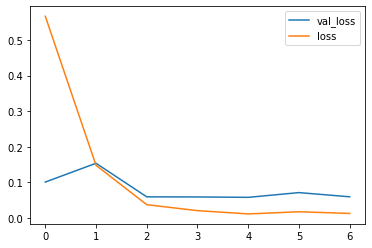

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['val_loss', 'loss']].plot()
print("Minimum Loss: {}".format(history_df['loss'].min()))
print("Minimum Validation Loss: {}".format(history_df['val_loss'].min()))

In [ ]:
pred = model.predict(X_test)
pred = pred.reshape(-1)
pred.tolist()
pred = [1 if x > 0.5 else 0 for x in pred]

In [ ]:
target_names = ['label_0', 'label_1']
print(classification_report(pred, y_test, target_names=target_names))

              precision    recall  f1-score   support

     label_0       0.99      0.98      0.99      3489
     label_1       0.98      0.99      0.99      3375

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864



In [ ]:
test_pred = model.predict(test_total)
test_pred = test_pred.reshape(-1)
test_pred.tolist()
test_pred = [1 if x > 0.5 else 0 for x in test_pred]
target_names = ['label_0', 'label_1']
print(classification_report(test_pred, solution, target_names=target_names))

              precision    recall  f1-score   support

     label_0       0.99      0.99      0.99      2616
     label_1       0.99      0.99      0.99      2584

    accuracy                           0.99      5200
   macro avg       0.99      0.99      0.99      5200
weighted avg       0.99      0.99      0.99      5200



In [ ]:
print(accuracy_score(test_pred, solution))
print(precision_score(test_pred, solution))

0.9911538461538462
0.9888289676425269


In [ ]:
new = input("Enter the headline of the news article along with the author name: ")
new_stemmed = porterstemmer(new)
new_df = pd.Series(new_stemmed)
tokenizer.fit_on_texts(new_df)
new_total = tokenizer.texts_to_sequences(new_df)
new_total = pad_sequences(new_total, maxlen=sentence_length)

Enter the headline of the news article along with the author name: I don't know what to do. -The HinduRidhi Thalaseima


In [ ]:
x = model.predict(new_total)
if x > 0.5:
  x = 1
else:
  x = 0

print("The news source is {}".format("unreliable" if x==1 else "reliable"))

The news source is unreliable


In [ ]:
model.predict(new_total)

array([[0.8478582]], dtype=float32)